# Bayesian Knowledge Tracing

In [ ]:
# Install an import
!pip install pyBKT
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Data

We will fit data from the Assistments platform (https://new.assistments.org/). These data are from the course 2012-2013. First make sure to download the data from https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/as.csv to the folder **./data/**.

In [6]:
!wget https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/as.csv
os.makedirs("data", exist_ok=True)

!mv as.csv data/as.csv

# Inspect the dataset
DATASET = "data/as.csv"
df = pd.read_csv(DATASET, encoding="latin", low_memory=False)
df.head()

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,...,0,3,32454,30799,NaN,26,0,NaN,1,1.0
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,...,0,3,4922,30799,NaN,55,0,NaN,2,2.0
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,...,0,3,42000,30799,NaN,88,0,NaN,1,1.0
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,...,0,3,4859,30059,NaN,41,0,NaN,2,2.0
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,...,3,4,124564,30060,NaN,65,0,0.0,3,3.0


Here we focus on the following variables:
- *user_id* - The ID of the student doing the problem.
- *problem_id* - The ID of the problem.
- *skill_name* - Skill name associated with the problem (knowledge component).
- *correct* - Whether the response was correct (1) or incorrect (0).
- *template_id* - Denotes a class of problems that are similar.

The remaining variables are explained here: https://sites.google.com/site/assistmentsdata/datasets/2012-13-school-data-with-affect

In [ ]:
print(
    "The dataset has {} observations, {} problems, {} skills and {} users".format(
        len(df),
        df["problem_id"].nunique(),
        df["skill_name"].nunique(),
        df["user_id"].nunique(),
    )
)

The dataset has 525534 observations, 26688 problems, 110 skills and 4217 users


Inspect the different skills:

In [ ]:
print(df["skill_name"].unique().tolist())

# Drop rows with missing skill_name
df = df.dropna(subset=["skill_name"])

['Box and Whisker', 'Circle Graph', 'Histogram as Table or Graph', 'Number Line', 'Scatter Plot', 'Stem and Leaf Plot', 'Table', 'Venn Diagram', 'Mean', 'Median', 'Mode', 'Range', 'Counting Methods', 'Probability of Two Distinct Events', 'Probability of a Single Event', 'Interior Angles Figures with More than 3 Sides', 'Interior Angles Triangle', 'Congruence', 'Complementary and Supplementary Angles', 'Angles on Parallel Lines Cut by a Transversal', 'Pythagorean Theorem', 'Nets of 3D Figures', 'Unit Conversion Within a System', 'Effect of Changing Dimensions of a Shape Prportionally', nan, 'Area Circle', 'Circumference ', 'Perimeter of a Polygon', 'Reading a Ruler or Scale', 'Calculations with Similar Figures', 'Conversion of Fraction Decimals Percents', 'Equivalent Fractions', 'Ordering Positive Decimals', 'Ordering Fractions', 'Ordering Integers', 'Ordering Real Numbers', 'Rounding', 'Addition Whole Numbers', 'Division Fractions', 'Estimation', 'Fraction Of', 'Least Common Multiple',

Inspect the data for a single student:

In [ ]:
df[df["user_id"] == 64525].sort_values("order_id")

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
288311,21441630,263315,64525,34563,54003,1,0,1,20797,tutor,...,0,0,20859,30677,NaN,-12.2,0,NaN,1,1.0
288312,21441970,263315,64525,34560,53991,1,1,1,13797,tutor,...,0,0,13797,30677,NaN,-6.5,0,NaN,2,2.0
288313,21442097,263315,64525,34580,54071,1,0,1,14172,tutor,...,0,0,14235,30677,NaN,1.6,0,NaN,3,3.0
288314,21442513,263315,64525,34566,54015,1,1,1,48813,tutor,...,0,0,48813,30677,NaN,5.2,0,NaN,4,4.0
288315,21442851,263315,64525,34559,53987,1,1,1,22187,tutor,...,0,0,22187,30677,NaN,1.4,0,NaN,5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446259,33273093,277671,64525,37536,59762,1,0,1,19048,tutor,...,0,0,19173,30988,NaN,y=1/5-4,0,NaN,12,6.0
446260,33273154,277671,64525,37536,59763,0,1,1,3978,tutor,...,0,4,3978,30988,NaN,5-Jan,0,NaN,13,NaN
446261,33273172,277671,64525,37536,59764,0,1,1,14960,tutor,...,0,2,14960,30988,NaN,-4,0,NaN,14,NaN
446262,33273227,277671,64525,37536,59765,0,1,1,7363,tutor,...,0,4,7363,30988,NaN,y=1/5x-4,0,NaN,15,NaN


## Model fitting
When calling the *fit* we can specify a list of skill names we want to fit (in this case "Venn Diagram",
    "Multiplication and Division Integers", "Box and Whisker"). The parameters are estimated separately for each skill. If no skills are indicated, the whole dataset is used, which may take a long time.

- **Parameters**:
    - num_fits (5) - the number of initialization fits used for the BKT model.
    - parallel (True) - whether to use multi-threading.
    - skills (all) - a list with the skills the model will be run on. It can also be a regular expression.
    - forgets (False) - include forgetting in the model.    

- **Inputs**:
The input dataframe should have the following columns:
    - order_id ('order_id') -  indicates question order.
    - skill_name ('skill_name') - skill name (knowledge component) associated with the question.
    - correct ('correct') - the correct (1) / incorrect (0) label.
    - user_id ('user_id') - name of the CSV column for the ID of the student answering the question.


It is possible to use other columns names, by passing a dict with the name mapping to the fit method (see below).

defaults = {'order_id': 'alternative_order_id',
            'skill_name': 'alternative_skill_name',
            'correct': 'alternative_correct'}

    
More details in https://github.com/CAHLR/pyBKT#creating-and-training-models

In [39]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

from pyBKT.models import Model



SKILL_LIST = [
    "Venn Diagram",
    "Multiplication and Division Integers",
    "Box and Whisker"
]



BKT = Model(seed=SEED, parallel=True)

BKT.fit(data=df, skills=SKILL_LIST, num_fits=3)

auc_train = BKT.evaluate(data=df, metric="auc")
accuracy_train = BKT.evaluate(data=df, metric="accuracy")

print(f"Training AUC: {auc_train}; Training accuracy: {accuracy_train}")

Training AUC: 0.8015132116287087; Training accuracy: 0.792882097310194


Inspect the estimated parameters.

- **prior** ($P(\text{L}_0)$) - the prior probability of knowledge concept (skill) mastery.
- **learns** ($P(\text{L})$) - the probability of transitioning to the mastery state given non-mastery, over a single learning opportunity.
- **slips** ($P(\text{S})$) - the probability of slipping (making a mistake) when the learner is in the mastered state.
- **guesses** ($P(\text{G})$) - the probability that the student guesses the right answer while not knowing the skill.
- **forgets** ($P(\text{F})$) - the probability of transitioning to the non-mastery state given mastery (i.e., forgetting something that the student previously learned).

There is a different set of parameters for each skill. Note that the **forgets** parameter is 0. If you run the fit with forgets=True it will also estimate this parameter (see below).

In [40]:
BKT.params()

value
skill                                param   class          
Multiplication and Division Integers prior   default 0.96799
                                     learns  default 0.01651
                                     guesses default 0.00017
                                     slips   default 0.21615
                                     forgets default 0.00000
Box and Whisker                      prior   default 0.77883
                                     learns  default 0.14003
                                     guesses default 0.31149
                                     slips   default 0.16785
                                     forgets default 0.00000
Venn Diagram                         prior   default 0.10572
                                     learns  default 0.01481
                                     guesses default 0.58209
                                     slips   default 0.00003
                                     forgets default 0.00000

In [41]:
# Alternatively
BKT.coef_

{'Multiplication and Division Integers': {'prior': 0.9679890115312564,
  'learns': array([0.01651189]),
  'guesses': array([0.0001733]),
  'slips': array([0.21615046]),
  'forgets': array([0.])},
 'Box and Whisker': {'prior': 0.7788269456401505,
  'learns': array([0.14002804]),
  'guesses': array([0.31148853]),
  'slips': array([0.16784541]),
  'forgets': array([0.])},
 'Venn Diagram': {'prior': 0.10571646647060393,
  'learns': array([0.0148101]),
  'guesses': array([0.58208979]),
  'slips': array([3.17227465e-05]),
  'forgets': array([0.])}}

# Prediction
Once we have trained a model we can make predictions. Here we use the training dataset, but normally we would be interested in applying it to new data.

In [42]:
pred = BKT.predict(data=df)

Inspect the predictions:
- *correct_predictions* - between 0 and 1, estimated probability of answering correctly.
- *state_predictions* - between 0 and 1, probability of mastering the knowledge component after responding to the item.

If pyBKT is asked for predictions on skills for which it has not trained a model, it will output 0.5 for both the correct and state predictions.

In [43]:
pred[pred["skill_name"] == SKILL_LIST[0]][
    [
        "user_id",
        "correct",
        "correct_predictions",
        "state_predictions",
        "skill_name",
    ]
].head(20)

,user_id,correct,correct_predictions,state_predictions,skill_name
26385,64525,1,0.62627,0.10572,Venn Diagram
26386,64525,1,0.65777,0.18111,Venn Diagram
26387,64525,1,0.70163,0.28606,Venn Diagram
26388,64525,1,0.75612,0.41647,Venn Diagram
26389,64525,1,0.81503,0.55743,Venn Diagram
26390,64525,1,0.86984,0.68860,Venn Diagram
26391,64525,1,0.91418,0.79470,Venn Diagram
26392,64525,0,0.94615,0.87121,Venn Diagram
26393,64525,0,0.58849,0.01532,Venn Diagram
26394,64525,1,0.58828,0.01481,Venn Diagram


## Cross-validation
We can also use cross-validation by specifying the number of folds to obtain better estimates of model performance. This will take some time to do the multiple fits.

In [44]:
cv = BKT.crossvalidate(data=df, folds=5, metric="auc", skills=SKILL_LIST)
cv

,auc
skill,
Multiplication and Division Integers,0.62581
Box and Whisker,0.63120
Venn Diagram,0.91218


##  Further extensions

### Enable forgetting

We train the model with forgets=True. This model assumes that the student can forget a concept previously learned. We will run these models using a single skills for to keep the training time short. Observe that the probability of forgetting a skill is rather low (as you would expect).

In [45]:
BKT.fit(data=df, skills=SKILL_LIST[0], forgets=True)
BKT.params()

value
skill        param   class          
Venn Diagram prior   default 0.60861
             learns  default 0.10618
             guesses default 0.03189
             slips   default 0.04694
             forgets default 0.01087

In [46]:
auc_train = BKT.evaluate(data=df, metric="auc")
accuracy_train = BKT.evaluate(data=df, metric="accuracy")

print(f"Training AUC: {auc_train}; Training accuracy: {accuracy_train}")

Training AUC: 0.9385992576346853; Training accuracy: 0.9025991792065663


### Multiguess
The **multiguess** option estimates different guess and slip parameters across sets of items. We need to include in the input data frame a column that designates a set of similar problems. The guess/slip are the same for each value of *template_id*. We need to indicate this column via the parameter *multigs*.

In [47]:
BKT.fit(data=df, skills=SKILL_LIST[0], multigs="template_id")
BKT.params()

value
skill        param   class          
Venn Diagram prior   default 0.27667
             learns  default 0.01090
             guesses 30041   0.73154
                     30046   0.75457
                     30304   0.60952
                     30328   0.64973
                     52495   0.33365
                     52497   0.63214
             slips   30041   0.17346
                     30046   0.09094
                     30304   0.23482
                     30328   0.21996
                     52495   0.02644
                     52497   0.00974
             forgets default 0.00000

In [48]:
auc_train = BKT.evaluate(data=df, metric="auc")
accuracy_train = BKT.evaluate(data=df, metric="accuracy")

print(f"Training AUC: {auc_train}; Training accuracy: {accuracy_train}")

Training AUC: 0.8578562732343925; Training accuracy: 0.840766073871409


We can now check the guess and slip parameters for each *template_id*.

<ipython-input-49-3e904a6927a3>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(params.loc[(SKILL_LIST[0], "guesses")], label="Guesses")
<ipython-input-49-3e904a6927a3>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(params.loc[(SKILL_LIST[0], "slips")], label="Slips")


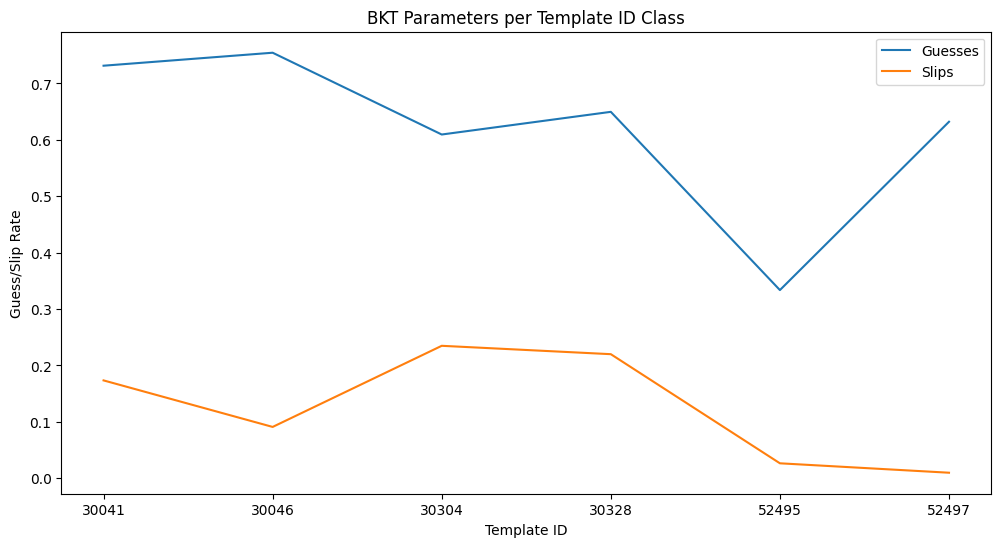

In [49]:
params = BKT.params()
plt.figure(figsize=(12, 6))
plt.plot(params.loc[(SKILL_LIST[0], "guesses")], label="Guesses")
plt.plot(params.loc[(SKILL_LIST[0], "slips")], label="Slips")
plt.xlabel("Template ID")
plt.ylabel("Guess/Slip Rate")
plt.title("BKT Parameters per Template ID Class")
plt.legend()

### Multilearn
The **multilearn** option estimates different learning rates (and forgetting rates when enabled) across sets of items. We need to include in the input data frame a column that designates a set of similar problems. Like before we can use *template_id* to aggregate items. We need to indicate this column via the parameter *multilearn*.

In [50]:
BKT.fit(data=df, skills=SKILL_LIST[0], multilearn="template_id", forgets=True)
BKT.params()

value
skill        param   class          
Venn Diagram prior   default 0.52871
             learns  30041   0.70918
                     30046   0.51762
                     30304   0.64537
                     30328   0.59754
                     52495   0.12388
                     52497   0.12635
             guesses default 0.00075
             slips   default 0.00008
             forgets 30041   0.19780
                     30046   0.24489
                     30304   0.36258
                     30328   0.16012
                     52495   0.01747
                     52497   0.02430

In [51]:
auc_train = BKT.evaluate(data=df, metric="auc")
accuracy_train = BKT.evaluate(data=df, metric="accuracy")

print(f"Training AUC: {auc_train}; Training accuracy: {accuracy_train}")

Training AUC: 0.9320000932412469; Training accuracy: 0.9035841313269494


<ipython-input-52-cc768521ffe5>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(params.loc[(SKILL_LIST[0], "learns")], label="Learn")
<ipython-input-52-cc768521ffe5>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(params.loc[(SKILL_LIST[0], "forgets")], label="Forget")


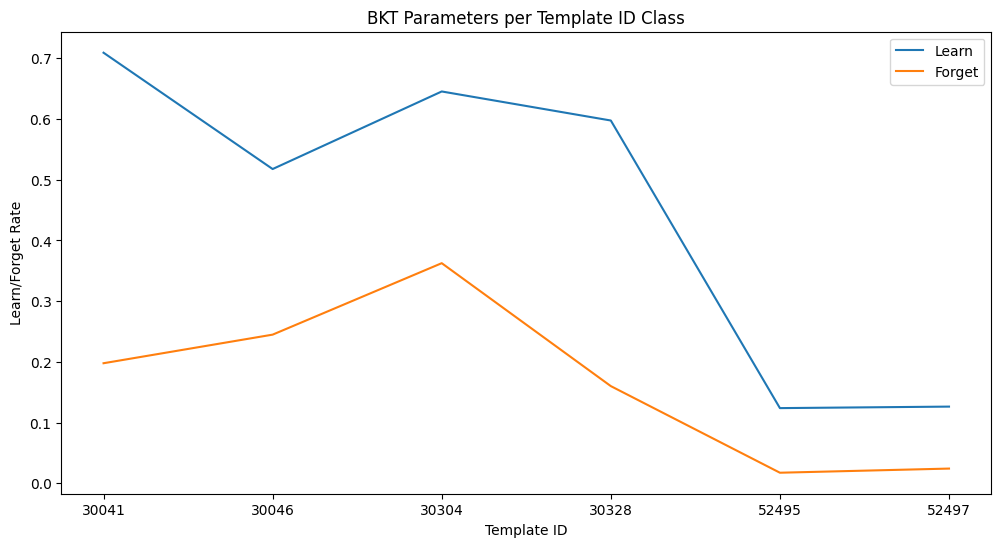

In [52]:
params = BKT.params()
plt.figure(figsize=(12, 6))
plt.plot(params.loc[(SKILL_LIST[0], "learns")], label="Learn")
plt.plot(params.loc[(SKILL_LIST[0], "forgets")], label="Forget")
plt.xlabel("Template ID")
plt.ylabel("Learn/Forget Rate")
plt.title("BKT Parameters per Template ID Class")
plt.legend()

# Exercise

Try to fit some of the BKT models to the Cognitive Tutor (https://ies.ed.gov/ncee/wwc/Docs/InterventionReports/wwc_cognitivetutor_062116.pdf) dataset, which can be downloaded from https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/ct.csv.

Fit one of the model extensions and plot the parameters across item sets.